In [88]:
#imports các thư viện
import numpy as np
from math import sqrt
from numpy import concatenate

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

from matplotlib import pyplot
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat


import keras.utils
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Bidirectional
from keras.layers import Input, concatenate, Dense
from keras.layers import LSTM, GRU
from sklearn.linear_model import LinearRegression
from keras.optimizers import Adam

import tensorflow as tf
import seaborn as sn
import seed
import os
tf.get_logger().setLevel('ERROR')

In [89]:
def rsi(data, period: int = 14):

    delta = data["Close"].diff()

    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    gain = up.ewm(com=(period - 1), min_periods=period).mean()
    loss = down.abs().ewm(com=(period - 1), min_periods=period).mean()

    RS = gain / loss
    return 100 - (100 / (1 + RS))

In [90]:
#lag granularity (độ trễ) - days or hours
lag_granularity = "days"
#lag value
lag = 1
# type of analyser - TextBlob or vader
analyser = "vader"
# analyser = "TextBlob"
#dataset grouped type - day or hour
dataset_grouped_by = "day"

In [91]:
#read dataset
folder = "./../../datasets/tweets_prices_volumes_sentiment/" + \
    analyser+"/"+dataset_grouped_by+"_datasets/cleaned"
filename = folder+"/final_data_lag_"+lag_granularity+"_" + \
    str(lag)+".csv" if (lag > 0) else folder+"/final_data_no_lag.csv"
df = pd.read_csv(filename, index_col='DateTime', parse_dates=True)

In [92]:
#group by datetime
df = df.groupby('DateTime').agg(lambda x: x.mean())
df

C:\Users\Windows 10\AppData\Local\Temp\ipykernel_9256\3489936249.py:2: FutureWarning: ['dt'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby('DateTime').agg(lambda x: x.mean())


,Close,Volume_(BTC),Weighted_Price,neg_pol,neu_pol,pos_pol,compound,Tweet_vol
DateTime,,,,,,,,
2018-08-30 00:00:00+00:00,7027.99,5.484323,6979.227679,0.043827,0.825543,0.130654,0.230801,557.0
2018-08-31 00:00:00+00:00,7187.23,3.694477,7097.021073,0.039833,0.847201,0.112971,0.196773,902.0
2018-09-01 00:00:00+00:00,7275.00,2.830380,7233.487967,0.036618,0.846208,0.117174,0.208065,818.0
2018-09-02 00:00:00+00:00,7301.01,2.130486,7260.380171,0.047145,0.837654,0.115190,0.163561,860.0
2018-09-03 00:00:00+00:00,7357.07,3.392408,7317.186602,0.045408,0.839805,0.114770,0.181093,980.0
...,...,...,...,...,...,...,...,...
2019-11-19 00:00:00+00:00,8085.36,2.133512,8098.781070,0.066980,0.751580,0.181439,0.269207,62924.0
2019-11-20 00:00:00+00:00,7618.17,7.593120,7834.680432,0.060034,0.744159,0.195808,0.297821,61536.0
2019-11-21 00:00:00+00:00,7272.99,16.570352,7301.606288,0.071387,0.744532,0.184078,0.250644,69663.0


In [93]:
#tính toán các chỉ số indicator: rsi, ma
#get change label
df["Change"] = (df["Close"] > df["Close"].shift(1)).astype(int)

add_RSI = True
add_longMAvg = True
add_shortMAvg = True

if(add_RSI):
    #calcualte RSI
    RSI = 14
    df['RSI'] = rsi(df, RSI)
    df = df.iloc[RSI:]

#calculate moving averages
if(add_shortMAvg):
    short_window = 9
    df['short_mavg'] = df.rolling(window=short_window)["Close"].mean()

if(add_longMAvg):
    long_window = 21
    df["long_mavg"] = df.rolling(window=long_window)["Close"].mean()

if(add_longMAvg):
    df = df.iloc[long_window:]
elif(add_RSI):
    df = df.iloc[RSI:]
elif(add_shortMAvg):
    df = df.iloc[short_window:]

C:\Users\Windows 10\AppData\Local\Temp\ipykernel_9256\259356298.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['short_mavg'] = df.rolling(window=short_window)["Close"].mean()
C:\Users\Windows 10\AppData\Local\Temp\ipykernel_9256\259356298.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["long_mavg"] = df.rolling(window=long_window)["Close"].mean()


In [94]:
#keep only wanted columns
features = ['Change', 'subjectivity', 'polarity', 'Tweet_vol', 'Volume_(BTC)'] if analyser == "Textblob" else [
    'Change', 'Close', 'pos_pol', 'neg_pol', 'Tweet_vol']

if(add_RSI):
    features.append("RSI")

if(add_longMAvg):
    features.append("long_mavg")

if(add_shortMAvg):
    features.append("short_mavg")

df = df[features]

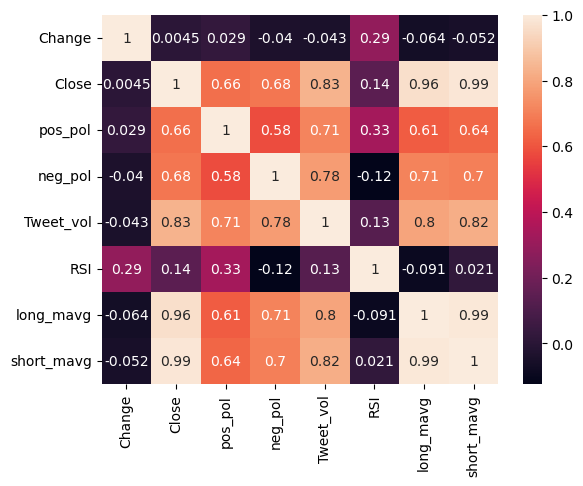

In [95]:
#plot correlation matrix
sn.heatmap(df.corr(), annot=True)
plt.show()


In [96]:
#creating copy so that data is not loaded once again
df_copy = df.copy()

In [97]:
#number of previous records to consider for every example
n_lag = 7
#number of features
n_features = len(features)
#calculate total_features
total_features = n_lag*n_features

if(total_features == 0):
    total_features = n_features

In [98]:
data_with_lagged = df_copy
data_with_lagged

,Change,Close,pos_pol,neg_pol,Tweet_vol,RSI,long_mavg,short_mavg
DateTime,,,,,,,,
2018-10-04 00:00:00+00:00,1,6558.37,0.109372,0.040379,833.0,48.836903,6531.749524,6567.716667
2018-10-05 00:00:00+00:00,0,6550.12,0.131859,0.041832,790.0,48.461841,6534.014762,6549.258889
2018-10-06 00:00:00+00:00,0,6532.00,0.130573,0.031604,601.0,47.597220,6535.592857,6538.434444
2018-10-07 00:00:00+00:00,1,6613.67,0.120965,0.034553,723.0,51.773599,6552.890000,6543.312222
2018-10-08 00:00:00+00:00,0,6581.04,0.119315,0.044390,687.0,50.057073,6565.130476,6546.205556
...,...,...,...,...,...,...,...,...
2019-11-19 00:00:00+00:00,0,8085.36,0.181439,0.066980,62924.0,35.295210,8838.712381,8454.672222
2019-11-20 00:00:00+00:00,0,7618.17,0.195808,0.060034,61536.0,28.520124,8766.839524,8326.661111
2019-11-21 00:00:00+00:00,0,7272.99,0.184078,0.071387,69663.0,24.741288,8674.864286,8162.943333


In [99]:
#divide df into train and test
train_ratio = 0.85
data_len = len(data_with_lagged)
train_size = int(data_len*train_ratio)

data_price = data_with_lagged.iloc[:, 1].reset_index().drop(['DateTime'], axis=1)

train = data_with_lagged.iloc[:train_size, 1]
train = train.reset_index()
train = train.drop(['DateTime'], axis=1)
train

,Close
0,6558.37
1,6550.12
2,6532.00
3,6613.67
4,6581.04
...,...
348,10192.25
349,10270.00
350,10130.00
351,9975.24


In [100]:
#chuẩn hóa
xscaler = MinMaxScaler(feature_range=(0, 1))
yscaler = MinMaxScaler(feature_range=(0, 1))
train = xscaler.fit_transform(train)
scaler_data = xscaler.transform(data_price)
# scaler_data = data_with_lagged
print(train.shape, scaler_data.shape)

(353, 1) (416, 1)


In [101]:
X_train = []
y_train = []

for i in range(n_lag, len(train)):
  X_train.append(train[i-n_lag:i, :])
  y_train.append(train[i, :])

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

print(X_train.shape, y_train.shape)

(346, 7, 1) (346, 1)


In [102]:

# design network
neurons = 64
epochs = 100
dropout = 0.25
batch_size = 80
activ_func = "relu"


In [103]:
# early stopping callback
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience =20)

In [104]:
# Số fold
k = 5
kf = KFold(n_splits=k, shuffle=False)

# List để lưu kết quả dự đoán từ LSTM và GRU
lstm_predictions = []
gru_predictions = []

lstm_models = []
gru_models = []

# Xây dựng mô hình stacking
for train_index, test_index in kf.split(X_train):
    X_sub_train, X_sub_test = X_train[train_index], X_train[test_index]
    y_sub_train, y_sub_test = y_train[train_index], y_train[test_index]
    # Xây dựng mô hình LSTM và huấn luyện
    lstm_model = Sequential()
    lstm_model.add(LSTM(neurons, return_sequences=True, input_shape=(
        X_train.shape[1], X_train.shape[2]), activation=activ_func))
    lstm_model.add(LSTM(neurons, return_sequences=False))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mean_squared_error')

    # Xây dựng mô hình GRU và huấn luyện
    gru_model = Sequential()
    gru_model.add(GRU(neurons, return_sequences=True, input_shape=(
        X_train.shape[1], X_train.shape[2]), activation=activ_func))
    gru_model.add(GRU(neurons, return_sequences=False))
    gru_model.add(Dense(1))
    gru_model.compile(optimizer='adam', loss='mean_squared_error')
    
    lstm_model.fit(X_sub_train, y_sub_train, epochs=epochs, batch_size=batch_size)

    gru_model.fit(X_sub_train, y_sub_train, epochs=epochs, batch_size=batch_size)

    # Lấy đầu ra của mô hình LSTM và GRU
    lstm_output = lstm_model.predict(X_sub_test)
    gru_output = gru_model.predict(X_sub_test)
    
    lstm_predictions.append(lstm_output)
    gru_predictions.append(gru_output)
    
    lstm_models.append(lstm_model)
    gru_models.append(gru_model)

Epoch 1/100
4/4 [==============================] - 3s 12ms/step - loss: 0.2160
Epoch 2/100
4/4 [==============================] - 0s 10ms/step - loss: 0.1248
Epoch 3/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0523
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0236
Epoch 5/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0357
Epoch 6/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0201
Epoch 7/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0125
Epoch 8/100
4/4 [==============================] - 0s 26ms/step - loss: 0.0138
Epoch 9/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0101
Epoch 10/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0048
Epoch 11/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0046
Epoch 12/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0041
Epoch 13/100
4/4 [==============================] -

In [105]:
type(lstm_predictions)

list

In [106]:
# Lấy đầu ra của LSTM và GRU
lstm_outputs = np.concatenate(lstm_predictions, axis=0)
gru_outputs = np.concatenate(gru_predictions, axis=0)


In [107]:
from numpy import column_stack

lstm_outputs = xscaler.inverse_transform(lstm_outputs)
gru_outputs = xscaler.inverse_transform(gru_outputs)

y_train = xscaler.inverse_transform(y_train)

stacking_inputs = column_stack((lstm_outputs, gru_outputs))

In [108]:
stacking_inputs

array([[ 6745.8667,  6641.691 ],
       [ 6653.5693,  6530.4316],
       [ 6547.8677,  6456.5522],
       [ 6462.378 ,  6424.0728],
       [ 6453.6084,  6480.4565],
       [ 6518.279 ,  6562.934 ],
       [ 6596.7715,  6616.5137],
       [ 6646.655 ,  6617.426 ],
       [ 6666.6494,  6611.3013],
       [ 6656.755 ,  6611.656 ],
       [ 6642.559 ,  6625.258 ],
       [ 6641.5186,  6625.5835],
       [ 6648.434 ,  6620.8384],
       [ 6656.7544,  6627.758 ],
       [ 6652.6216,  6622.6763],
       [ 6646.2153,  6616.3574],
       [ 6645.4644,  6618.354 ],
       [ 6643.8545,  6615.234 ],
       [ 6619.644 ,  6564.5205],
       [ 6588.2603,  6524.5015],
       [ 6561.026 ,  6512.638 ],
       [ 6542.967 ,  6523.1836],
       [ 6546.262 ,  6537.7456],
       [ 6563.462 ,  6541.7827],
       [ 6591.5596,  6571.9253],
       [ 6610.396 ,  6593.961 ],
       [ 6631.545 ,  6621.7056],
       [ 6664.946 ,  6662.64  ],
       [ 6683.1597,  6658.616 ],
       [ 6673.0527,  6614.707 ],
       [ 6

In [109]:
# stacking_model = Sequential()
# stacking_model.add(Dense(2, input_shape=(stacking_inputs.shape[1],)))
# stacking_model.add(Dense(1, activation='linear'))
# stacking_model.compile(optimizer='adam', loss='mean_squared_error')

stacking_model = LinearRegression()

# Train stacking model
stacking_model.fit(stacking_inputs, y_train)

LinearRegression()

In [110]:
#tạo testing data set
test_data = scaler_data[train_size - n_lag: , :]
x_test = []
y_test = data_with_lagged.iloc[train_size:, 1]
y_test = y_test.reset_index()
y_test = y_test.drop(['DateTime'], axis=1)

for i in range(n_lag, len(test_data)):
  x_test.append(test_data[i-n_lag:i, :])

x_test = np.asarray(x_test)
print(x_test.shape, y_test.shape)

(63, 7, 1) (63, 1)


In [111]:
#get the models predicted price value
lstm_test_predictions = []
gru_test_predictions = []

for i in range(5):
  lstm_test_prediction = lstm_models[i].predict(x_test)
  gru_test_prediction = gru_models[i].predict(x_test)
  
  lstm_test_prediction = xscaler.inverse_transform(lstm_test_prediction)
  gru_test_prediction = xscaler.inverse_transform(gru_test_prediction)
  
  lstm_test_predictions.append(lstm_test_prediction)
  gru_test_predictions.append(gru_test_prediction)

lstm_test_predictions = sum(lstm_test_predictions) / len(lstm_test_predictions)
gru_test_predictions = sum(gru_test_predictions) / len(gru_test_predictions)

stacking_close_predictions = stacking_model.predict(column_stack((lstm_test_predictions, gru_test_predictions)))

# stacking_close_predictions = xscaler.inverse_transform(stacking_close_predictions)
# stacking_close_predictions.to_csv("pred-price.csv", index=False)
stacking_close_predictions.shape

2/2 [==============================] - 0s 6ms/step


(63, 1)

In [112]:
#sai số
mse = np.mean((y_test - stacking_close_predictions)**2)
mae = np.mean(np.abs(y_test - stacking_close_predictions))
mape = np.mean(np.abs((y_test - stacking_close_predictions) / y_test)) * 100
smape = 200 * np.mean(np.abs((y_test - stacking_close_predictions) / (np.abs(y_test) + np.abs(stacking_close_predictions))))
print(mse["Close"], mae["Close"], mape["Close"], smape["Close"])

#sai số
mseLSTM = np.mean((y_test - lstm_test_predictions)**2)
maeLSTM = np.mean(np.abs(y_test - lstm_test_predictions))
mapeLSTM = np.mean(np.abs((y_test - lstm_test_predictions) / y_test)) * 100
smapeLSTM = 200 * np.mean(np.abs((y_test - lstm_test_predictions) / (np.abs(y_test) + np.abs(lstm_test_predictions))))
print(mseLSTM["Close"], maeLSTM["Close"], mapeLSTM["Close"], smapeLSTM["Close"])

#sai số
mseGRU = np.mean((y_test - gru_test_predictions)**2)
maeGRU = np.mean(np.abs(y_test - gru_test_predictions))
mapeGRU = np.mean(np.abs((y_test - gru_test_predictions) / y_test)) * 100
smapeGRU = 200 * np.mean(np.abs((y_test - gru_test_predictions) / (np.abs(y_test) + np.abs(gru_test_predictions))))
print(mseGRU["Close"], maeGRU["Close"], mapeGRU["Close"], smapeGRU["Close"])


110404.78363000062 210.757138516865 2.495886413680665 2.497871942643461
257093.11563855674 381.1502015128968 4.567731170158856 4.478838079675544
160491.3885461055 296.9775747147817 3.5548509409711206 3.501612823113811


c:\Users\Windows 10\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\Windows 10\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\Windows 10\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\Windows

C:\Users\Windows 10\AppData\Local\Temp\ipykernel_9256\871103454.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['SE'] = stacking_close_predictions
C:\Users\Windows 10\AppData\Local\Temp\ipykernel_9256\871103454.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['LSTM'] = lstm_test_predictions
C:\Users\Windows 10\AppData\Local\Temp\ipykernel_9256\871103454.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

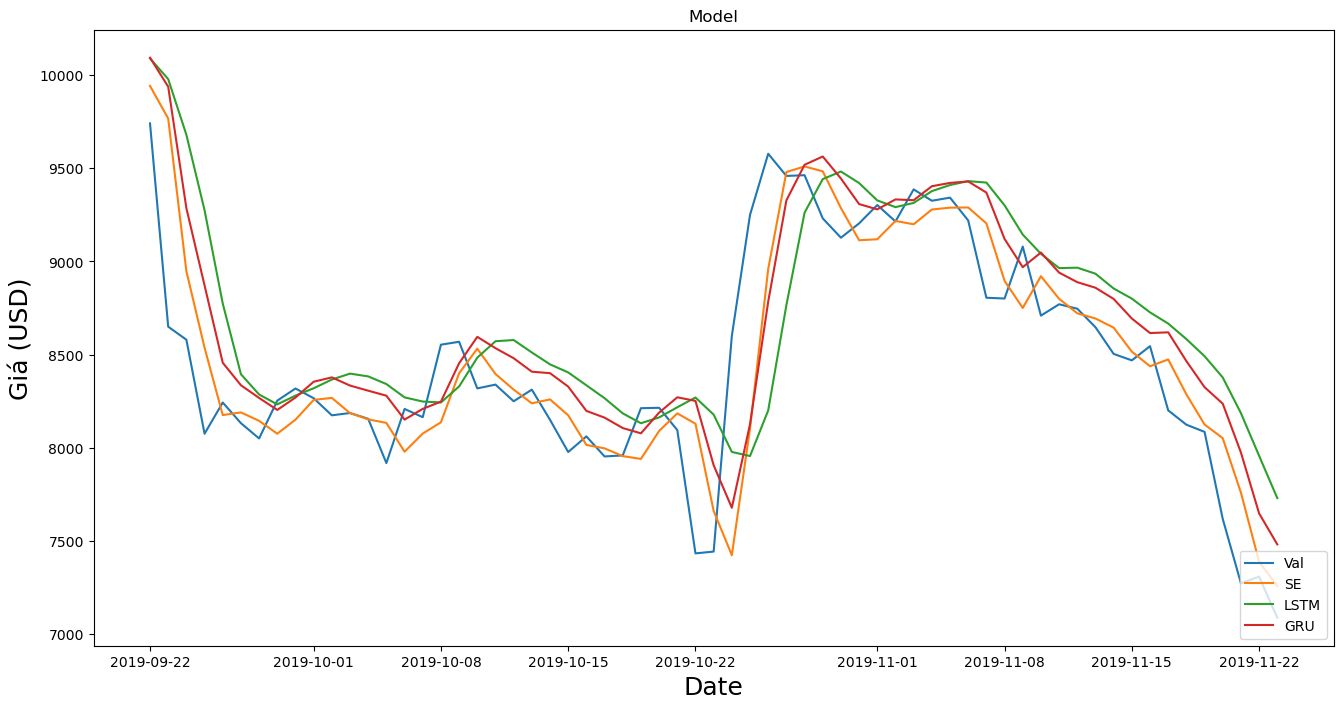

In [113]:
#
valid = data_with_lagged[train_size:]
valid['SE'] = stacking_close_predictions
valid['LSTM'] = lstm_test_predictions
valid['GRU'] = gru_test_predictions

#hiển thị dữ liệu gần đây
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Giá (USD)', fontsize=18)
plt.plot(valid[['Close','SE','LSTM', 'GRU']])
plt.legend(['Val', 'SE', 'LSTM', 'GRU'], loc='lower right')
plt.show()

In [114]:
#create file if it does not exist
data = {
    'Model': 'SE',
    'Thông tin': ['MAE', 'MSE', 'MAPE', 'sMAPE'],
    'Price': [mae["Close"], mse["Close"], mape["Close"], smape["Close"]]
}
result_table = pd.DataFrame(data)
result_table.to_csv("result.csv", index=False)
result_table

,Model,Thông tin,Price
0,SE,MAE,210.757139
1,SE,MSE,110404.783630
2,SE,MAPE,2.495886
3,SE,sMAPE,2.497872


In [117]:
valid["PredSE"] = (valid["SE"] > valid["SE"].shift(1)).astype(int)
valid["PredLSTM"] = (valid["LSTM"] > valid["LSTM"].shift(1)).astype(int)
valid["PredGRU"] = (valid["GRU"] > valid["GRU"].shift(1)).astype(int)
valid["CorrectSE"] = (valid["PredSE"] - valid["Change"]) == 0
valid["CorrectLSTM"] = (valid["PredLSTM"] - valid["Change"]) == 0
valid["CorrectGRU"] = (valid["PredGRU"] - valid["Change"]) == 0
incorrect = valid.loc[valid['CorrectSE'] == False]
incorrect_len = len(incorrect)
prices_len = len(valid)
print("Accuracy = ",((prices_len-incorrect_len + 1)/prices_len))
print("Accuracy = ",((len(valid.loc[valid['CorrectLSTM'] == True]) + 1)/prices_len))
print("Accuracy = ",((len(valid.loc[valid['CorrectGRU'] == True]) + 1)/prices_len))
valid

C:\Users\Windows 10\AppData\Local\Temp\ipykernel_9256\1211922701.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["PredSE"] = (valid["SE"] > valid["SE"].shift(1)).astype(int)
C:\Users\Windows 10\AppData\Local\Temp\ipykernel_9256\1211922701.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["PredLSTM"] = (valid["LSTM"] > valid["LSTM"].shift(1)).astype(int)
C:\Users\Windows 10\AppData\Local\Temp\ipykernel_9256\1211922701.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Accuracy =  0.5714285714285714
Accuracy =  0.5555555555555556
Accuracy =  0.5396825396825397


,Change,Close,pos_pol,neg_pol,Tweet_vol,RSI,long_mavg,short_mavg,SE,LSTM,GRU,PredSE,PredLSTM,PredGRU,CorrectSE,CorrectLSTM,CorrectGRU
DateTime,,,,,,,,,,,,,,,,,
2019-09-22 00:00:00+00:00,0,9741.16,0.184098,0.065074,51779.0,38.511407,10292.353810,10130.570000,9942.129883,10089.939453,10093.611328,0,0,0,True,True,True
2019-09-23 00:00:00+00:00,0,8650.00,0.184604,0.063351,66469.0,25.192000,10194.713333,9947.237778,9767.329102,9978.828125,9938.183594,0,0,0,True,True,True
2019-09-24 00:00:00+00:00,0,8580.00,0.175963,0.081008,81359.0,24.604109,10095.094286,9756.558889,8947.979492,9680.043945,9286.071289,0,0,0,True,True,True
2019-09-25 00:00:00+00:00,0,8075.42,0.172008,0.079452,76116.0,20.830542,9977.017143,9519.101111,8537.289062,9274.899414,8871.300781,0,0,0,True,True,True
2019-09-26 00:00:00+00:00,1,8242.95,0.173780,0.078020,70832.0,24.946425,9873.458095,9302.512222,8175.411133,8774.394531,8456.427734,0,0,0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-19 00:00:00+00:00,0,8085.36,0.181439,0.066980,62924.0,35.295210,8838.712381,8454.672222,8124.825195,8491.583984,8325.168945,0,0,0,True,True,True
2019-11-20 00:00:00+00:00,0,7618.17,0.195808,0.060034,61536.0,28.520124,8766.839524,8326.661111,8051.483887,8377.265625,8236.653320,0,0,0,True,True,True
2019-11-21 00:00:00+00:00,0,7272.99,0.184078,0.071387,69663.0,24.741288,8674.864286,8162.943333,7759.017578,8185.872070,7974.712402,0,0,0,True,True,True
